In [ ]:
"""

 - training a tiny policy (LSTM) on a toy token-generation task using a reward model (RM)
 - adversarial RM training loop (Adv-RM): an adversary produces high-RM-scoring but low-quality outputs; these are labeled and added to RM training
 - conservative/regularized policy updates (KL to base policy)
 - simple RM ensemble / uncertainty scoring

Designed to run quickly on CPU or a single GPU in Colab. All models are tiny; dataset is synthetic.

--------
1) Imports & utils
2) Toy dataset (prompts + ground-truth target quality) and synthetic human labels (pairwise)
3) Models: BasePolicy (SFT), Policy (trainable), RewardModel (RM), Adversary (policy copy)
4) RM training loop (pairwise loss + BSR regularizer)
5) PPO-like policy update with KL regularization (simplified)
6) Adversarial generation & labeling
7) Full Adv-RM training loop with monitoring
8) Quick experiments & plotting

"""

'\nAdv-RM + PPO — Minimal reproducible Colab notebook\nFile: adv_rm_ppo_toy.py\n\nPurpose\n-------\nA compact, runnable PyTorch notebook that demonstrates:\n - training a tiny policy (LSTM) on a toy token-generation task using a reward model (RM)\n - adversarial RM training loop (Adv-RM): an adversary produces high-RM-scoring but low-quality outputs; these are labeled and added to RM training\n - conservative/regularized policy updates (KL to base policy)\n - simple RM ensemble / uncertainty scoring\n\nDesigned to run quickly on CPU or a single GPU in Colab. All models are tiny; dataset is synthetic.\n\nHow to run\n----------\nCopy this file into a Colab Python cell or save as a .py and run. Each section is clearly delimited.\n\nSections\n--------\n1) Imports & utils\n2) Toy dataset (prompts + ground-truth target quality) and synthetic human labels (pairwise)\n3) Models: BasePolicy (SFT), Policy (trainable), RewardModel (RM), Adversary (policy copy)\n4) RM training loop (pairwise loss 

In [ ]:
# === 1) Imports & helpers ===
import math
import random
from copy import deepcopy
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

In [ ]:


# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# simple tokenizer for toy vocab
VOCAB = [f"T{i}" for i in range(20)]  # 20 tokens
vocab_size = len(VOCAB)
PAD = vocab_size

# helpers
def seq_to_tensor(seq: List[int]) -> torch.LongTensor:
    return torch.tensor(seq, dtype=torch.long, device=device)

# sample categorical with temperature
def categorical_sample(logits: torch.Tensor) -> int:
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).item()

# decode
def decode_seq(seq: List[int]) -> str:
    return ' '.join(VOCAB[t] if t < vocab_size else '<PAD>' for t in seq)

# === 2) Toy dataset ===
# We create prompts paired with a "true quality" function: sequences matching a hidden rule are high-quality,
# others are low-quality. RM must learn this; adversary tries to exploit RM blindspots.

PROMPT_COUNT = 200
SEQ_LEN = 6

# Hidden rule: high-quality if tokens contain pattern [1,2,3] in order (not necessarily contiguous)
GOOD_PATTERN = [1,2,3]

prompts = [torch.randint(0, vocab_size, (3,), device=device).tolist() for _ in range(PROMPT_COUNT)]


Device: cpu


In [ ]:


# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# simple tokenizer for toy vocab
VOCAB = [f"T{i}" for i in range(20)]  # 20 tokens
vocab_size = len(VOCAB)
PAD = vocab_size

# helpers
def seq_to_tensor(seq: List[int]) -> torch.LongTensor:
    return torch.tensor(seq, dtype=torch.long, device=device)

# sample categorical with temperature
def categorical_sample(logits: torch.Tensor) -> int:
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).item()

# decode
def decode_seq(seq: List[int]) -> str:
    return ' '.join(VOCAB[t] if t < vocab_size else '<PAD>' for t in seq)

# === 2) Toy dataset ===
# We create prompts paired with a "true quality" function: sequences matching a hidden rule are high-quality,
# others are low-quality. RM must learn this; adversary tries to exploit RM blindspots.

PROMPT_COUNT = 200
SEQ_LEN = 6

# Hidden rule: high-quality if tokens contain pattern [1,2,3] in order (not necessarily contiguous)
GOOD_PATTERN = [1,2,3]

prompts = [torch.randint(0, vocab_size, (3,), device=device).tolist() for _ in range(PROMPT_COUNT)]



Device: cpu


In [ ]:

# ground-truth evaluator (simulated human): returns score 1 for good, 0 for bad
def true_quality(prompt: List[int], response: List[int]) -> int:
    # high quality if GOOD_PATTERN appears in combined prompt+response in order
    combined = prompt + response
    idx = 0
    for t in combined:
        if t == GOOD_PATTERN[idx]:
            idx += 1
            if idx == len(GOOD_PATTERN):
                return 1
    return 0

# Create small human preference dataset D_pref: for some prompts, generate pairs (A,B) with human pref
D_pref = []  # list of (prompt, seqA, seqB, pref) pref=1 if A preferred else 0
for p in prompts[:100]:
    r1 = torch.randint(0, vocab_size, (SEQ_LEN,), device=device).tolist()
    q1 = true_quality(p, r1)

    # Try to generate a second response with a different quality
    r2 = None
    q2 = -1 # Initialize to a value that won't match q1
    attempts = 0
    while q1 == q2 and attempts < 20: # Limit attempts to avoid infinite loop
        r2 = torch.randint(0, vocab_size, (SEQ_LEN,), device=device).tolist()
        q2 = true_quality(p, r2)
        attempts += 1

    # If after attempts, still q1 == q2, just use the last generated r2
    if r2 is None:
        r2 = torch.randint(0, vocab_size, (SEQ_LEN,), device=device).tolist()
        q2 = true_quality(p, r2)

    pref = 1 if q1 > q2 else 0 # Prefer r1 if its quality is higher
    D_pref.append((p, r1, r2, pref))

print('Initial preference pairs:', len(D_pref))

# small validation set
D_val = D_pref[:min(50, len(D_pref))]


Initial preference pairs: 100


In [ ]:


# === 3) Models ===

class TinyPolicy(nn.Module):
    """A tiny LSTM policy that given a prompt generates a sequence of SEQ_LEN tokens."""
    def __init__(self, vocab_size, emb=32, hid=64):
        super().__init__()
        self.emb = nn.Embedding(vocab_size + 1, emb)  # +1 for PAD
        self.lstm = nn.LSTM(emb, hid, batch_first=True)
        self.head = nn.Linear(hid, vocab_size)

    def forward(self, prompt_tokens: torch.LongTensor, gen_steps=SEQ_LEN):
        # prompt_tokens: (prompt_len,) list of ints
        # We'll run autoregressively but in an efficient loop
        prompt_emb = self.emb(prompt_tokens.unsqueeze(0))  # 1 x prompt_len x emb
        h, c = (torch.zeros(1, 1, self.lstm.hidden_size, device=device),
                torch.zeros(1, 1, self.lstm.hidden_size, device=device))
        # feed prompt to initialize hidden state
        _, (h, c) = self.lstm(prompt_emb, (h, c))
        outputs = []
        input_tok = torch.tensor([PAD], device=device)  # start with PAD token
        for _ in range(gen_steps):
            out = self.emb(input_tok.unsqueeze(0))  # 1 x 1 x emb
            out, (h, c) = self.lstm(out, (h, c))
            logits = self.head(out.squeeze(0))  # 1 x vocab
            outputs.append(logits.squeeze(0))
            input_tok = torch.multinomial(F.softmax(logits.squeeze(0), dim=-1), 1)
        # outputs: list of logits per step
        return torch.stack(outputs, dim=0)  # seq_len x vocab


In [ ]:

class RewardModel(nn.Module):
    """Simple RM: encodes prompt+response via embeddings and an MLP to scalar reward."""
    def __init__(self, vocab_size, emb=32, hid=64):
        super().__init__()
        self.emb = nn.Embedding(vocab_size + 1, emb)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.mlp = nn.Sequential(
            nn.Linear(emb, hid), nn.ReLU(), nn.Linear(hid, 1)
        )

    def forward(self, prompt_tokens: torch.LongTensor, resp_tokens: torch.LongTensor):
        # tokens: 1D tensors
        x = torch.cat([prompt_tokens, resp_tokens], dim=0)
        e = self.emb(x)  # L x emb
        # mean-pool
        v = e.mean(dim=0)
        return self.mlp(v).squeeze(0)

In [ ]:



# create SFT/base policy (untrained snapshot) and trainable policy
base_policy = TinyPolicy(vocab_size).to(device)
policy = TinyPolicy(vocab_size).to(device)
# initialize policy from base
policy.load_state_dict(deepcopy(base_policy.state_dict()))

# reward model and ensemble
rm = RewardModel(vocab_size).to(device)
rm_ensemble = [RewardModel(vocab_size).to(device) for _ in range(3)]

# optimizers
rm_opt = optim.Adam(list(rm.parameters()) + [p for m in rm_ensemble for p in m.parameters()], lr=1e-3)
policy_opt = optim.Adam(policy.parameters(), lr=1e-3)


In [ ]:
# === 4) RM training utilities ===

def pairwise_loss(rm_model: RewardModel, batch):
    # batch: list of (prompt, r1, r2, pref) where pref==1 if r1 preferred
    losses = []
    for (p, a, b, pref) in batch:
        p_t = seq_to_tensor(p) # Fixed: pass list directly
        a_t = seq_to_tensor(a) # Fixed: pass list directly
        b_t = seq_to_tensor(b) # Fixed: pass list directly
        sa = rm_model(p_t, a_t)
        sb = rm_model(p_t, b_t)
        # logistic loss for pairwise
        if pref == 1:
            losses.append(F.binary_cross_entropy_with_logits(sa - sb, torch.tensor(1.0, device=device)))
        else:
            losses.append(F.binary_cross_entropy_with_logits(sb - sa, torch.tensor(1.0, device=device)))
    return torch.stack(losses).mean()

# Batch-wise sum-to-zero regularizer (BSR)
def bsr_loss(rm_model: RewardModel, batch):
    vals = []
    for (p, a, b, pref) in batch:
        p_t = seq_to_tensor(p) # Fixed: pass list directly
        a_t = seq_to_tensor(a) # Fixed: pass list directly
        b_t = seq_to_tensor(b) # Fixed: pass list directly
        vals.append(rm_model(p_t, a_t))
        vals.append(rm_model(p_t, b_t))
    vals = torch.stack(vals)
    return (vals.mean())**2  # push mean toward zero

# RM ensemble scoring and uncertainty
# Removed @torch.no_grad() from rm_score_and_var to allow gradient flow
def rm_score_and_var(ensemble, prompt, resp):
    p_t = seq_to_tensor(prompt) # Fixed: pass list directly
    r_t = seq_to_tensor(resp) # Fixed: pass list directly
    scores = torch.stack([m(p_t, r_t) for m in ensemble])
    return scores.mean(), scores.var().item() # return mean as tensor, var as item

In [ ]:
# === 5) Simple PPO-like update (very small) ===

def compute_kl_between_policies(policy_a: TinyPolicy, policy_b: TinyPolicy, prompt_tokens):
    # approximate KL by sampling many sequences and computing log-probs under both
    N = 16
    kl = 0.0
    for _ in range(N):
        # sample sequence from policy_a but get logprobs
        logits_seq = policy_a(prompt_tokens)
        logp_a = 0.0
        logp_b = 0.0
        for logits in logits_seq:
            probs_a = F.log_softmax(logits, dim=-1)
            probs_b = F.log_softmax(policy_b.head(policy_b.lstm(policy_b.emb(torch.tensor([PAD], device=device)).unsqueeze(0))[0].squeeze(0)), dim=-1)
            # this is a rough approx; keep it simple by comparing per-step argmax probs
            tok = torch.argmax(logits).item()
            logp_a += probs_a[tok]
            # fallback: use zeros for b
            logp_b += probs_b[0,0] if isinstance(probs_b, torch.Tensor) else 0.0
        kl += (logp_a - logp_b).item()
    return kl / N

# We'll use a simpler KL: L2 on parameter differences as a proxy

def param_l2_diff(model_a, model_b):
    sq = 0.0
    for pa, pb in zip(model_a.parameters(), model_b.parameters()):
        sq += ((pa - pb)**2).sum().item()
    return math.sqrt(sq)

# policy update using REINFORCE with baseline, plus L2 toward base policy (proxy for KL)

def policy_update(policy, base_policy, prompts_batch, rewards_batch, policy_opt, kl_coef=1e-2):
    policy.train()
    loss = None
    policy_opt.zero_grad()
    # REINFORCE: sum log p(seq) * (reward - baseline)
    baseline = rewards_batch['rews'].mean() # Fixed: access 'rews' key
    total_loss = 0.0
    for prompt, seq, r in zip(prompts_batch, rewards_batch['seqs'], rewards_batch['rews']):
        # get logprobs of generated seq under current policy
        # run policy deterministically to get logits sequence
        logits_seq = policy(seq_to_tensor(prompt)) # Fixed: pass list directly
        logp = 0.0
        for tok, logits in zip(seq, logits_seq):
            logp += F.log_softmax(logits, dim=-1)[tok]
        # REINFORCE objective (negative to minimize)
        total_loss += -(logp) * (r - baseline)
    # regularize toward base policy by L2 param distance
    l2 = 0.0
    for pa, pb in zip(policy.parameters(), base_policy.parameters()):
        l2 += ((pa - pb)**2).sum()
    total_loss = total_loss + kl_coef * l2
    total_loss.backward()
    policy_opt.step()
    return total_loss.item()

In [ ]:


adversary = TinyPolicy(vocab_size).to(device)
adversary.load_state_dict(deepcopy(policy.state_dict()))
adversary_opt = optim.Adam(adversary.parameters(), lr=5e-4)

# adversary training step: update adversary to produce sequences with high RM score

In [ ]:
adversary = TinyPolicy(vocab_size).to(device)
adversary.load_state_dict(deepcopy(policy.state_dict()))
adversary_opt = optim.Adam(adversary.parameters(), lr=5e-4)

# adversary training step: update adversary to produce sequences with high RM score

def train_adversary_step(adversary, rm_ensemble, prompts_batch, opt, iters=10):
    adversary.train()
    for _ in range(iters):
        losses = []
        opt.zero_grad()
        for p in prompts_batch:
            # Fixed: pass list directly to seq_to_tensor
            logits_seq = adversary(seq_to_tensor(p))
            # sample seq
            seq = [categorical_sample(logits) for logits in logits_seq]
            # score via RM ensemble
            score, _ = rm_score_and_var(rm_ensemble, p, seq) # score is now a tensor
            # maximize score -> minimize negative
            losses.append(-score) # Append the tensor directly
        loss = torch.stack(losses).mean()
        loss.backward()
        opt.step()
    return loss.item()

# labeler: calls true_quality; returns labeled pairs to add to D_pref

def label_adversarial_examples(prompts_batch, adv_examples):
    # adv_examples: list of seqs matched to prompts
    new_pairs = []
    for p, seq in zip(prompts_batch, adv_examples):
        # create a contrastive low-quality random seq
        rand_seq = torch.randint(0, vocab_size, (SEQ_LEN,), device=device).tolist()
        human_pref = 1 if true_quality(p, seq) > true_quality(p, rand_seq) else 0
        # add pair (p, seq, rand_seq, human_pref)
        new_pairs.append((p, seq, rand_seq, human_pref))
    return new_pairs

In [ ]:
# === 7) Full Adv-RM training loop ===

EPOCHS = 20
RM_STEPS = 10
PPO_STEPS = 15
ADV_ITERS = 5
BATCH_SIZE = 16

# convenience: sample batch helper

def sample_pref_batch(dataset, batch_size=BATCH_SIZE):
    return random.sample(dataset, min(batch_size, len(dataset)))

# simple monitor
history = {'rm_loss': [], 'policy_loss': [], 'adv_loss': [], 'val_corr': [], 'adv_success_rate': []}

for epoch in range(EPOCHS):
    # 1) Train RM on D_pref
    rm.train()
    for _ in range(RM_STEPS):
        batch = sample_pref_batch(D_pref)
        loss = pairwise_loss(rm, batch)
        bsr = bsr_loss(rm, batch) * 0.1
        rm_opt.zero_grad()
        (loss + bsr).backward()
        rm_opt.step()
    history['rm_loss'].append(loss.item())

    # 2) Train policy using RM as reward (REINFORCE + KL proxy)
    policy.train()
    # sample prompts and get rewards
    prompts_batch = random.sample(prompts[:120], BATCH_SIZE)
    seqs = []
    rews = []
    for p in prompts_batch:
        # Fixed: pass list directly to seq_to_tensor
        logits_seq = policy(seq_to_tensor(p))
        seq = [categorical_sample(logits) for logits in logits_seq]
        seqs.append(seq)
        # Note: here we use rm_score_and_var for policy training, where we want the actual score, not necessarily requiring grad.
        # However, since we removed @torch.no_grad from the function itself, we need to explicitly use torch.no_grad() here
        # if we don't want policy training to backpropagate into RM parameters (which we usually don't).
        with torch.no_grad():
            r_tensor, var = rm_score_and_var([rm] + rm_ensemble, p, seq)
        r = r_tensor.item() # Convert back to float for policy reward
        # apply pessimism: scale down reward by variance
        r_adj = r * (1.0 / (1.0 + var))
        rews.append(r_adj)
    rewards_batch = {'seqs': seqs, 'rews': torch.tensor(rews, device=device)}
    pol_loss = policy_update(policy, base_policy, prompts_batch, rewards_batch, policy_opt, kl_coef=1e-3)
    history['policy_loss'].append(pol_loss)

    # 3) Adversarial generation: train adversary to maximize RM
    adv_prompts = random.sample(prompts[:120], BATCH_SIZE)
    adv_loss = train_adversary_step(adversary, [rm] + rm_ensemble, adv_prompts, adversary_opt, iters=ADV_ITERS)
    history['adv_loss'].append(adv_loss)

    # adversary generates candidate sequences
    adversary.eval()
    adv_candidates = []
    for p in adv_prompts[:BATCH_SIZE//2]:
        # Fixed: pass list directly to seq_to_tensor
        logits_seq = adversary(seq_to_tensor(p))
        seq = [categorical_sample(logits) for logits in logits_seq]
        adv_candidates.append(seq)

    # label adv candidates with true_quality
    new_pairs = label_adversarial_examples(adv_prompts[:len(adv_candidates)], adv_candidates)
    D_pref.extend(new_pairs)

    # measure adversarial success: fraction of adv candidates that RM scores high but are low-quality
    success = 0
    for p, seq in zip(adv_prompts[:len(adv_candidates)], adv_candidates):
        with torch.no_grad(): # Use no_grad for evaluation metrics
            rm_score_tensor, var = rm_score_and_var([rm] + rm_ensemble, p, seq)
        rm_score = rm_score_tensor.item() # Convert to float for comparison
        human_q = true_quality(p, seq)
        if rm_score > 0.5 and human_q == 0:
            success += 1
    adv_success_rate = success / max(1, len(adv_candidates))
    history['adv_success_rate'].append(adv_success_rate)

    # validation: correlation RM vs human on D_val
    corr_count = 0
    for p, a, b, pref in D_val:
        with torch.no_grad(): # Use no_grad for evaluation metrics
            s_a_tensor, _ = rm_score_and_var([rm] + rm_ensemble, p, a)
            s_b_tensor, _ = rm_score_and_var([rm] + rm_ensemble, p, b)
        s_a = s_a_tensor.item() # Convert to float for comparison
        s_b = s_b_tensor.item() # Convert to float for comparison
        pred_pref = 1 if s_a > s_b else 0
        if pred_pref == pref:
            corr_count += 1
    val_corr = corr_count / max(1, len(D_val))
    history['val_corr'].append(val_corr)

    print(f'Epoch {epoch+1}/{EPOCHS}: rm_loss={loss.item():.4f}, policy_loss={pol_loss:.4f}, adv_loss={adv_loss:.4f}, val_corr={val_corr:.3f}, adv_succ={adv_success_rate:.3f}')

Epoch 1/20: rm_loss=0.6782, policy_loss=-0.0153, adv_loss=0.0763, val_corr=0.600, adv_succ=0.000
Epoch 2/20: rm_loss=0.6881, policy_loss=-0.0310, adv_loss=0.0573, val_corr=0.660, adv_succ=0.000
Epoch 3/20: rm_loss=0.6339, policy_loss=0.0583, adv_loss=0.0344, val_corr=0.660, adv_succ=0.000
Epoch 4/20: rm_loss=0.6705, policy_loss=-0.0253, adv_loss=0.0485, val_corr=0.640, adv_succ=0.000
Epoch 5/20: rm_loss=0.6614, policy_loss=-0.0627, adv_loss=0.0386, val_corr=0.700, adv_succ=0.000
Epoch 6/20: rm_loss=0.5924, policy_loss=-0.0136, adv_loss=0.0262, val_corr=0.680, adv_succ=0.000
Epoch 7/20: rm_loss=0.6495, policy_loss=-0.2127, adv_loss=0.0500, val_corr=0.720, adv_succ=0.000
Epoch 8/20: rm_loss=0.6079, policy_loss=-0.0654, adv_loss=0.0509, val_corr=0.700, adv_succ=0.000
Epoch 9/20: rm_loss=0.6642, policy_loss=-0.0196, adv_loss=0.0647, val_corr=0.720, adv_succ=0.000
Epoch 10/20: rm_loss=0.5819, policy_loss=-0.1635, adv_loss=0.0646, val_corr=0.720, adv_succ=0.000
Epoch 11/20: rm_loss=0.5495, p

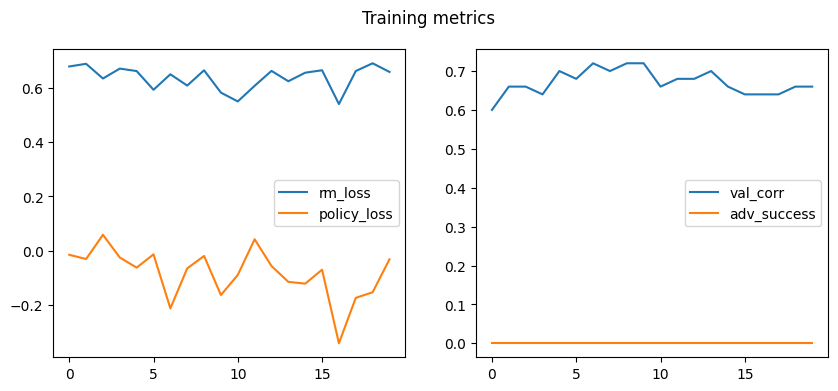

Done — tiny Adv-RM + PPO demo complete.
Tips:
- Increase RM capacity or dataset to observe different behaviors.
- Replace labeler with human annotations for realistic training.
- Add pessimistic RM training (penalize high rewards on OOD) by adding negative examples and scaling.
Saved checkpoint to /content/adv_rm_demo_ckpt.pth


In [ ]:

# === 8) Quick plots (matplotlib) ===
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['rm_loss'], label='rm_loss')
plt.plot(history['policy_loss'], label='policy_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history['val_corr'], label='val_corr')
plt.plot(history['adv_success_rate'], label='adv_success')
plt.legend()
plt.suptitle('Training metrics')
plt.show()

# === End of notebook ===
print('Done — tiny Adv-RM + PPO demo complete.\nTips:')
print('- Increase RM capacity or dataset to observe different behaviors.')
print('- Replace labeler with human annotations for realistic training.')
print('- Add pessimistic RM training (penalize high rewards on OOD) by adding negative examples and scaling.')

# Save a quick checkpoint if you want
torch.save({
    'policy': policy.state_dict(),
    'rm': rm.state_dict(),
}, '/content/adv_rm_demo_ckpt.pth')
print('Saved checkpoint to /content/adv_rm_demo_ckpt.pth')
